# Global and Local Explanation for KNN model on MIT data


In [76]:
import sys
import os
data_path = ''
# Check if the environment is Google Colab
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install matplotlib -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your own google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    
else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/raw/'

Path = dict({
    'mit_test': data_path +  'mitbih_test_clean.csv',
    'mit_train':  data_path + 'mitbih_train_clean.csv',
})

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


In [77]:
# Verify installation and import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import pickle

In [78]:
def addColumnsToDataframe(df):
    """
    As the dataset is composed with 188 columns with the 188th columns as the category values,
    so we give the last column the name 'target', others named with 'c_182'
    """
    num_columns= df.shape[1]
    feature_col_name = ['c_' + str(i) for i in range(0, num_columns - 1)]
    df_columns = feature_col_name + ['target']
    df.columns = df_columns
    return df

def convertColumnAsInt(df, column):
    """
    As the category value is in float type. We want to get the int to identify the category.
    """
    df[column] = df[column].astype(int)
    return df

def getBarChartFromCategoryValueCounts(category_value_counts):
    """
    We call the plot over the pandas series object to plot the category count values
    """
    plt.figure(figsize=(10, 6))
    bar_chart = category_value_counts.plot(kind='bar')
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(False)
    plt.xticks(rotation=360)
    for i in bar_chart.containers:
        bar_chart.bar_label(i, label_type='edge')
    plt.show()


def showTop10DataInChart(df):
    plt.figure(figsize=(10, 6))
    xDataAxis = list(range(0, df.shape[1]))
    yDataRows = list(df.values[1: 10])
    for y in yDataRows:
        plt.plot(xDataAxis, y)
    plt.show()

In [79]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from xgboost import XGBModel, Booster
import os

# Load the data
mit_train = pd.read_csv(Path['mit_train'])
mit_test = pd.read_csv(Path['mit_test'])

# Remove duplicates
mit_train = mit_train.drop_duplicates()
mit_test = mit_test.drop_duplicates()

# Prepare the data
mit_train = addColumnsToDataframe(mit_train)
mit_test = addColumnsToDataframe(mit_test)
mit_train = convertColumnAsInt(mit_train, 'target')
mit_test = convertColumnAsInt(mit_test, 'target')

# Split data into features and target
X_train = mit_train.drop(columns=['target'])
y_train = mit_train['target']
X_test = mit_test.drop(columns=['target'])
y_test = mit_test['target']

# Define the model path
current_dir = os.getcwd()
model_path = os.path.join(current_dir, '..', 'models', 'model_knn_mit.pkl')


In [80]:
y_test.value_counts()

target
0    18118
1     2166
Name: count, dtype: int64

load model

In [81]:
# Load the pipeline model from the pickle file
with open(model_path, 'rb') as file:
    pipeline_model = pickle.load(file)

# Check the type of the model (pipeline)
print(f"Model type: {type(pipeline_model)}")

# Print the names of the pipeline steps
print("Pipeline steps (names and objects):")
for step_name, step_obj in pipeline_model.named_steps.items():
    print(f"{step_name}: {type(step_obj)}")

# Alternatively, you can get the dictionary of steps directly:
steps_dict = pipeline_model.named_steps
print("Available steps in the pipeline:", steps_dict.keys())


Model type: <class 'imblearn.pipeline.Pipeline'>
Pipeline steps (names and objects):
scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
oversampling: <class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'>
model: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Available steps in the pipeline: dict_keys(['scaler', 'oversampling', 'model'])


## Perlmutation Feature Importance

KNN is an instance-based, non-parametric algorithm that makes predictions based on the distances to nearby points, and it doesn’t assign weights or importance values to features inherently. Hence, KNN does not have a built-in way of determining feature importance. 

Evaluates the importance of each feature by measuring the decrease in model performance when the feature values are shuffled. After 120 min no solution!

In [83]:
# from sklearn.inspection import permutation_importance

# # Calculate permutation feature importance
# result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# # Create a DataFrame with the feature importances
# feature_importance_df = pd.DataFrame({
#     'feature': X_test.columns,
#     'importance': result.importances_mean
# })

# # Sort the DataFrame based on feature importance
# feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# # Display the top 10 most important features
# top_10_features = feature_importance_df.head(10)
# print(top_10_features)

# # Display the top 10 least important features
# least_10_features = feature_importance_df.tail(10)
# print(least_10_features)

# # Plot the top 10 most important features
# plt.figure(figsize=(12, 8))
# sns.barplot(
#     x='importance', 
#     y='feature', 
#     data=top_10_features, 
#     palette='viridis'
# )
# plt.title('KNN: Top 10 Most Important Features in MIT (X_test)')
# plt.xlabel('Mean Decrease in Accuracy')
# plt.ylabel('Features')
# plt.show()


## SHAP Values

Try this piece of code if you have enough memory:

In [104]:
# # Initialize KernelExplainer using the entire training dataset
# explainer = shap.KernelExplainer(pipeline_model.named_steps['model'].predict, X_train)

# # Calculate SHAP values for the entire test set (note that this can take considerable time)
# shap_values = explainer.shap_values(X_test)

# # Convert the SHAP values to a numpy array
# shap_values_array = np.array(shap_values)

# # Calculate the mean absolute SHAP values for each feature
# mean_shap_values = np.abs(shap_values_array).mean(axis=0)

# # Create a DataFrame to store feature importances
# shap_importance_df = pd.DataFrame({
#     'feature': X_test.columns,
#     'importance': mean_shap_values
# })

# # Sort the DataFrame based on feature importance
# shap_importance_df = shap_importance_df.sort_values(by='importance', ascending=False)

# # Display the top 10 most important features based on SHAP values
# top_10_shap_features = shap_importance_df.head(10)
# print("Top 10 most important features based on SHAP values:\n", top_10_shap_features)

# # Plot the top 10 most important features based on SHAP values (bar chart)
# plt.figure(figsize=(12, 8))
# sns.barplot(
#     x='importance', 
#     y='feature', 
#     data=top_10_shap_features, 
#     palette='viridis'
# )
# plt.title('SHAP: Top 10 Most Important Features in MIT (X_test)')
# plt.xlabel('Mean Absolute SHAP Value')
# plt.ylabel('Features')
# plt.show()

# # Plot a SHAP summary plot for the top 10 features (summary dot plot)
# plt.figure(figsize=(12, 8))
# shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10, feature_names=X_test.columns)


Since I get a MemoryError: Unable to allocate 274. GiB for an array with shape (2422, 15170001) and data type float64, I will use only a sample: Attention took me still 100 mins!!!


100%|██████████| 50/50 [1:40:06<00:00, 120.12s/it]  

Top 10 most important features based on SHAP values:
     feature  importance
2       c_2    0.030895
84     c_84    0.028012
90     c_90    0.024073
101   c_101    0.023874
102   c_102    0.023761
88     c_88    0.022401
85     c_85    0.022373
89     c_89    0.022126
83     c_83    0.021179
0       c_0    0.021137



C:\Users\Isabell Gurstein\AppData\Local\Temp\ipykernel_9460\2272002339.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


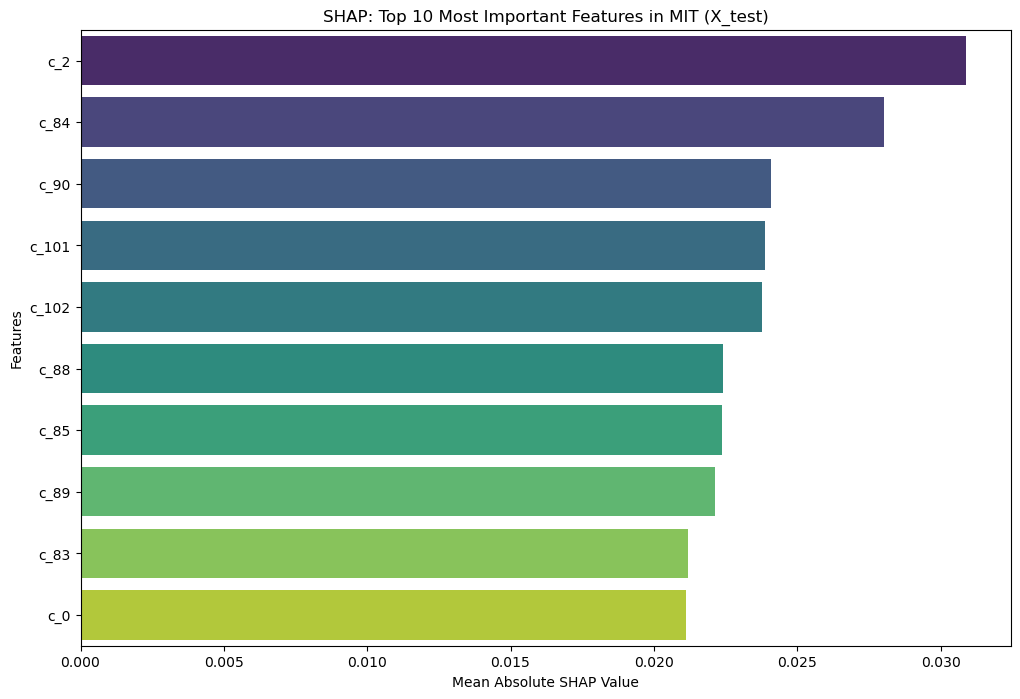

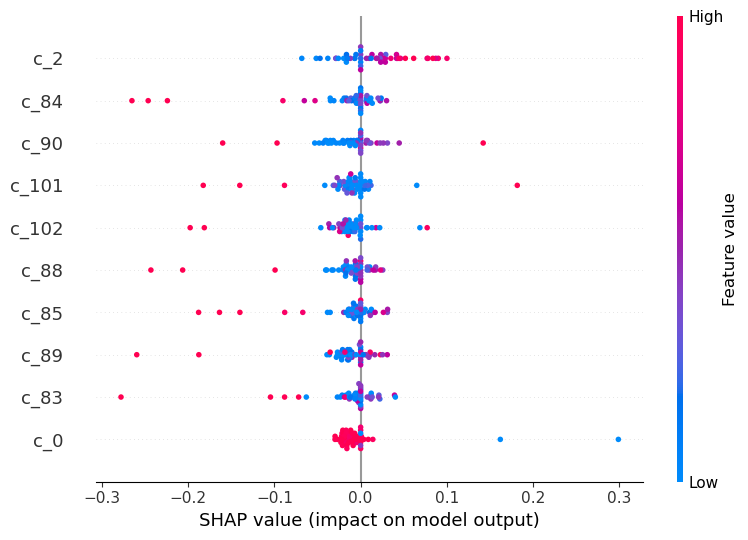

In [89]:
# Reduce data precision to save memory
X_train = X_train.astype(np.float32) # Reduce precision to 32-bit float to save memory
X_test = X_test.astype(np.float32) #32-bit float to save memory because the data is not very large

# Summarize the background data using k-means clustering to improve runtime efficiency
X_train_summary = shap.kmeans(X_train, 10)  # Summarize background to 10 clusters. Clusters are used to calculate SHAP values

# Initialize KernelExplainer using the summarized training dataset
explainer = shap.KernelExplainer(pipeline_model.named_steps['model'].predict, X_train_summary)

# Sample a smaller portion of X_test for SHAP calculations to handle memory limitations
X_test_sample = X_test.sample(n=50, random_state=42)  # Reduced `n` to 50 to handle memory and runtime issues

# Calculate SHAP values for the sample
shap_values_sample = explainer.shap_values(X_test_sample)

# Convert the SHAP values to a numpy array
shap_values_array = np.array(shap_values_sample)

# Calculate the mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values_array).mean(axis=0)

# Create a DataFrame to store feature importances
shap_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': mean_shap_values
})

# Sort the DataFrame based on feature importance
shap_importance_df = shap_importance_df.sort_values(by='importance', ascending=False)

# Display the top 10 most important features based on SHAP values
top_10_shap_features = shap_importance_df.head(10)
print("Top 10 most important features based on SHAP values:\n", top_10_shap_features)

# Plot the top 10 most important features based on SHAP values (bar chart)
plt.figure(figsize=(12, 8))
sns.barplot(
    x='importance', 
    y='feature', 
    data=top_10_shap_features, 
    palette='viridis'
)
plt.title('SHAP: Top 10 Most Important Features in MIT (X_test)')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.show()

# Plot a SHAP summary plot for the top 10 features (summary dot plot)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_sample, X_test_sample, plot_type="dot", max_display=10, feature_names=X_test.columns)


In [102]:
# Save the SHAP summary plot as an image
output_dir = os.path.join(os.getcwd(), 'images')
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'shap_summary_plot.png'))

<Figure size 640x480 with 0 Axes>

In [103]:
shap.summary_plot(shap_values_sample, X_test_sample, plot_type="dot", max_display=10, feature_names=X_test.columns, show=False)
plt.savefig(os.path.join(output_dir, 'knn_shap_summary_plot.png'))
plt.close()

LIME


True Label for selected instance: 0
Instance features:
 c_0      0.980392
c_1      0.696078
c_2      0.193627
c_3      0.009804
c_4      0.061275
           ...   
c_182    0.000000
c_183    0.000000
c_184    0.000000
c_185    0.000000
c_186    0.000000
Name: 200, Length: 187, dtype: float32


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

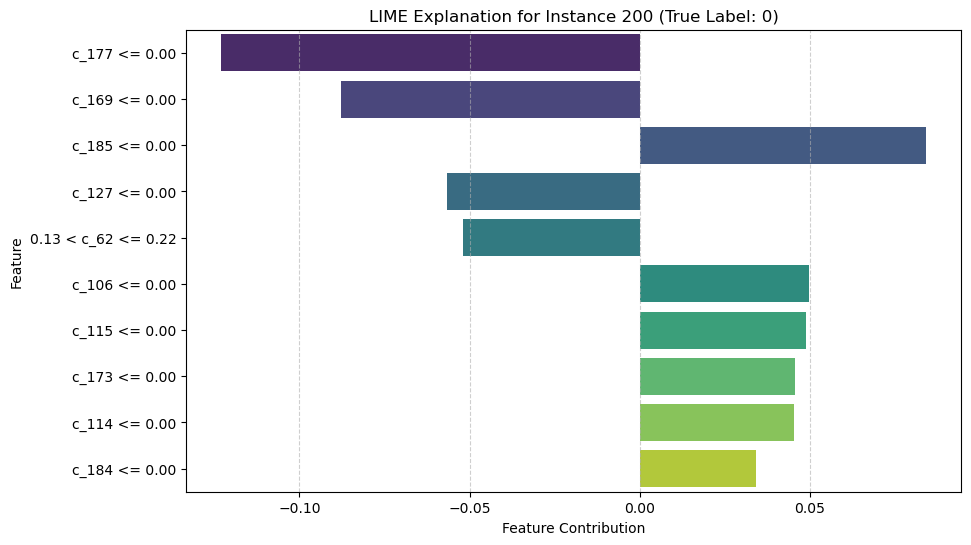

In [90]:
# load lime
import lime
import lime.lime_tabular


# Create a Lime Explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),  # Features from the training data
    training_labels=np.array(y_train),  # Target labels for training data
    mode="classification",  # Set to 'classification' or 'regression' based on your task
    feature_names=X_train.columns,  # Feature names
    class_names=['Class 0', 'Class 1'],  # Class names for binary classification (modify if more classes)
    discretize_continuous=True  # Discretizes continuous features for better explanation
)

# Select a random instance from the test set
idx = 200  ################################  You can change this index to select a different instance! ##############################
instance = X_test.iloc[idx]  # The input instance

# Get the true label for the selected instance
true_label = y_test.iloc[idx]

print("True Label for selected instance:", true_label)
print("Instance features:\n", instance)

# Explain the instance using the LIME explainer
exp = explainer.explain_instance(
    data_row=instance,  # Instance to explain
    predict_fn=pipeline_model.predict_proba,  # Prediction function from the model
    num_features=10  # Number of features to include in the explanation
)

# Extract feature contributions from the explanation object
feature_importance = exp.as_list()  # Returns a list of (feature, contribution) tuples

# Convert the feature importance to a DataFrame for easy visualization
lime_df = pd.DataFrame(feature_importance, columns=['Feature', 'Contribution'])

# Plot the LIME explanation using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Contribution', 
    y='Feature', 
    data=lime_df, 
    palette='viridis', 
    orient='h'
)
plt.title(f'LIME Explanation for Instance {idx} (True Label: {true_label})')
plt.xlabel('Feature Contribution')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()